# Description
This notebook shows the procedure to calculate and plot the energetic distribution of producing all proteins in the CHO secretome (a total of 5,641 proteins with signal peptide or localized in membrane) as well as in the CHO proteome (25,827 proteins)

In [1]:
# Load important packages
import os
import numpy as np
import pandas as pd
from Bio import ExPASy, SwissProt
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
#matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
os.chdir(os.getcwd())
import scipy.stats as sc
import statsmodels.formula.api as smf
import statsmodels.api as sm

## 1. Load CHO and Human secretome PSIM
In this table, SP=1 refers to those proteins with signal peptide predicted computationally with [PrediSI](http://www.predisi.de/)

In [2]:
cho_psim = pd.read_csv("iCHO2048s_python/PSIM_CHO.tab",sep='\t')
cho_psim.head()

,Entry,Protein names,Length,Mass,SP,DSB,GPI,NG,OG,TMD,Location,Sequence
0,A0A061HTA7,Basal cell adhesion molecule-like protein,307,33884.0,1,0,0,0,0,0,NaN,MEPPDARAGLLWLALLLAGHSGSAASGYRSPFSLRIQTHSPAQVTH...
1,A0A061HTB1,Ectonucleotide pyrophosphatase/phosphodiestera...,592,67636.0,1,0,0,0,0,0,NaN,MYEGILMSTVISLFTFAIGVNICLGFTASRIKRAEWDEGPPTALSD...
2,A0A061HTB2,Ectonucleotide pyrophosphatase/phosphodiestera...,914,105105.0,1,0,0,0,0,0,NaN,MARKGSFGSYQVISLFTFAIGVNICLGFTASRIKRAEWDEGPPTAL...
3,A0A061HTB3,Collectin-10-like protein,82,8843.0,1,0,1,0,0,0,NaN,MSGFRVLLQSNQFILLLLLLLQFQSLGLDIDSRPAAEVCATHTISP...
4,A0A061HTB8,Carcinoembryonic antigen-related cell adhesion...,247,27490.0,1,0,0,0,0,0,NaN,MESPSLLLCKGLLLTAFLLTCWNTPTTAELTIELVPPKVAEGGNSV...


In [3]:
human_psim = pd.read_csv("RECON2s_python/PSIM_HUMAN.tab",sep='\t')
human_psim.head()

,Entry,Protein names,Length,Mass,SP,DSB,GPI,NG,OG,TMD,Location,Sequence
0,O95714,E3 ubiquitin-protein ligase HERC2 (EC 2.3.2.26...,4834,527228,0,0,0,0,0,0,[c],MPSESFCLAAQARLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...
1,Q9Y543,Transcription factor HES-2 (Class B basic heli...,173,18470,0,0,0,0,0,0,[n],MGLPRRAGDAAELRKSLKPLLEKRRRARINQSLSQLKGLILPLLGR...
2,P06865,Beta-hexosaminidase subunit alpha (EC 3.2.1.52...,529,60703,1,3,0,3,0,0,[l],MTSSRLWFSLLLAAAFAGRATALWPWPQNFQTSDQRYVLYPNNFQF...
3,B2RPK0,Putative high mobility group protein B1-like 1...,211,24238,0,0,0,0,0,0,[n],MGKGDPKKPRGKMSSYAFFVQTCREEHKKKHSDASVNFSEFSNKCS...
4,P26927,Hepatocyte growth factor-like protein (Macroph...,711,80320,1,20,0,3,0,0,[e],MGWLPLLLLLTQCLGVPGQRSPLNDFQVLRGTELQHLLHAVVPGPW...


# Define ATP cost calculator

## Function to compute cost (in ATP equivalents) for all proteins in CHO secretome
 
The cost of producing any secretory protein (in $ATP_{eq}$) can be computed as the sum of the following:

* Number of BiP-atp = $Protein_{length}  /  40$     ([ref](http://www.cshperspectives.com/content/5/5/a013201.full))
* 2 atp's for translocation initiation
* 22 atp's for degradation of signal peptide
* The number of atp's involved in COPII vesicular transport (which is a function of protein weight and Kv)
* The number of atp's involved in secretory vesicular transport (which is a function of protein weight and Kv)
* Synthesis cost of a protein (sum of amino acid biosynthesis energy cost with translational machinery polymerization cost)

$$ATPcost_{protein} = \Sigma_{20 aa} k_n \times c_n + \Sigma 4L-1$$

Where $L$ is the length of the protein

Kv = percentage of vesicular volume occupied by recombinant protein (assumed to be 70%)

In [5]:
# Read this table first
aa_cost = pd.read_csv('Table C - Amino acid bioenergetic costs.csv')
aas = list(aa_cost['Amino acid'])
aac = list(aa_cost['ATP cost'])

In [54]:
def getProteinSecretionCost(sequence,MW): #For proteins not in Uniprot database (e.g. Drugbank, proprietary protein)
    Kv = 0.8
    V = MW * 1.21 / 1000.0 # Protein Volume in nm^3
    clathrin_coeff = int(round(29880.01 * Kv / V)) # Number of proteins per clathrin vesicle  
    copii_coeff = int(round(268082.35 * Kv / V))
    ##### Compute relevant costs
    L = len(sequence)
    # Amino acid biosynthesis cost
    aminoacid_cost = 0
    for i in range(len(aas)):
        aminoacid_cost = aminoacid_cost + aac[i]
    # Add translation cost
    translation_cost = float(4*L) - 1 # ATP = 2L, GTP = 2L
    sp_cost = 22.0
    transloc_cost = 2.0
    bip_cost = float(L)/40.0
    copii_cost = 192.0/copii_coeff
    secretion_cost = 44.0/clathrin_coeff
    return aminoacid_cost + translation_cost + sp_cost + transloc_cost + bip_cost + copii_cost + secretion_cost

# 2. Compute all costs for Proteins in PSIM

In [55]:
ATPeq_cost = np.zeros(len(cho_psim))
for i in range(len(cho_psim)):
    s = cho_psim['Sequence'][i]
    w = cho_psim['Mass'][i]
    ATPeq_cost[i] = getProteinSecretionCost(s,w)
cho_psim['ATPeq_Cost'] = ATPeq_cost

In [56]:
ATPeq_cost = np.zeros(len(human_psim))
for i in range(len(human_psim)):
    s = human_psim['Sequence'][i]
    w = human_psim['Mass'][i]
    ATPeq_cost[i] = getProteinSecretionCost(s,w)
human_psim['ATPeq_Cost'] = ATPeq_cost

# Create secretome PSIM

In [4]:
secretome_psim_cho = cho_psim[cho_psim['SP']==1].copy().reset_index(drop=True)
secretome_psim_human = human_psim[human_psim['SP']==1].copy().reset_index(drop=True)

# 3. Plot histogram of energetic cost in CHO secretome

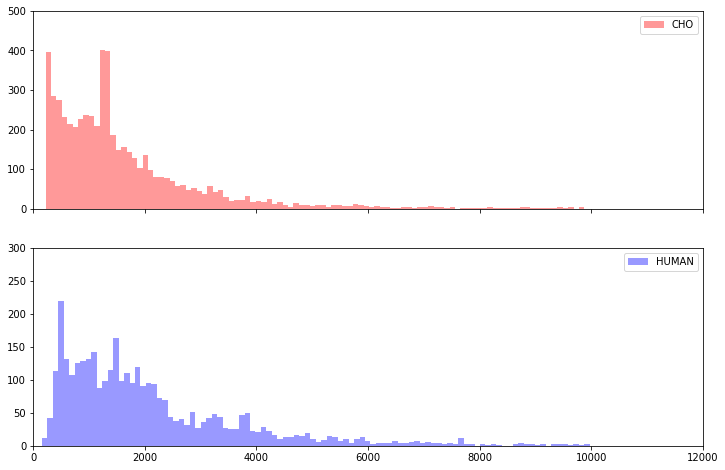

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=False,figsize=(12,8))
x1 = secretome_psim_cho['ATPeq_Cost'].values
ax1.hist(x1[x1<=10000],bins=100,alpha=0.4,color='r',label='CHO')
ax1.axis([0,12000,0,500])
ax1.legend()
x2 = secretome_psim_human['ATPeq_Cost'].values
ax2.hist(x2[x2<=10000],bins=100,alpha=0.4,color='b',label='HUMAN')
ax2.legend()
ax2.axis([0,12000,0,300])
fig.savefig('Histogram.pdf')

# 4. Plot ATPcost-Expression correlation in Kallehauge et al. experiments

In [8]:
ribo = pd.read_excel('NB3_Kallehauge_QpPredictions_Riboseq.xlsx')
ribo.head()

,Entry,Protein names,Length_human,Mass,SP,DSB,GPI,NG,OG,TMD,Location,Sequence,CHO,GeneID,Max_qp,ribo_day3,ribo_day6,pr_seq,Length_cho,ATP cost
0,O95714,E3 ubiquitin-protein ligase HERC2 (EC 2.3.2.26...,4834,527228,0,0,0,0,0,0,[c],MPSESFCLAAQARLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...,100758957,8924,0.000012,2.035375,2.114966,MPSESFCLAAQSRLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...,4836,19456.850
1,Q9Y543,Transcription factor HES-2 (Class B basic heli...,173,18470,0,0,0,0,0,0,[n],MGLPRRAGDAAELRKSLKPLLEKRRRARINQSLSQLKGLILPLLGR...,100756407,54626,0.000487,5.054750,2.124275,MRLPRRAGDAAELRKTLKPLLEKRRRARINQSLSQLKGLVLPLLGA...,157,696.325
2,P06865,Beta-hexosaminidase subunit alpha (EC 3.2.1.52...,529,60703,1,3,0,3,0,0,[l],MTSSRLWFSLLLAAAFAGRATALWPWPQNFQTSDQRYVLYPNNFQF...,100750552,3073,0.000000,23.655896,21.823740,MAGCRLWVSLLLAAALASSATAVWPWPQYIQTYHRRYTLYPNNFQF...,528,2129.225
3,P26927,Hepatocyte growth factor-like protein (Macroph...,711,80320,1,20,0,3,0,0,[e],MGWLPLLLLLTQCLGVPGQRSPLNDFQVLRGTELQHLLHAVVPGPW...,100761444,4485,0.000000,0.187897,0.393387,MPNVSPQNPPKHCLINIKDSQGSSYIKKVLALDPRARGLTSPSNCH...,806,2861.775
4,P14210,Hepatocyte growth factor (Hepatopoietin-A) (Sc...,728,83134,1,19,0,4,1,0,NaN,MWVTKLLPALLLQHVLLHLLLLPIAIPYAEGQRKRRNTIHEFKKSA...,100764472,3082,0.000000,1.867040,0.865297,MLLPLPLFPDRYVNTFIFLFKRGELVLCLCLDLAIGLSLAPPFPTR...,808,2930.200


In [9]:
atp_cost = []
for i in range(len(ribo)):
    s = ribo['pr_seq'][i]
    w = ribo['Mass'][i]
    atp_cost.append(getProteinSecretionCost(s,w))
ribo['ATP cost'] = atp_cost    

Text(0.5,1,u'Ribosome Profiling on early phase of culture')

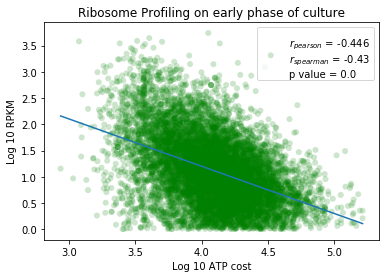

In [37]:
# Make scatter plots
X = np.array(ribo['ATP cost'])
Y = ribo['ribo_day3']
X = X[Y>=1] # Take only genes with RPKM values greater or equal than 1
Y = Y[Y>=1]
X = np.log10(X)
Y = np.log10(Y)
# Compute Spearman correlations
P,Pp_val = sc.pearsonr(X,Y)
S,Sp_val = sc.spearmanr(X,Y)
plt.scatter(X,Y,alpha=0.2,c='green',edgecolors='none',label='$r_{pearson}$ = '+ str(round(P,3)) + '\n$r_{spearman}$ = ' + str(round(S,3)) \
           + '\np value = ' + str(round(Pp_val,3)))
plt.ylabel('Log 10 RPKM')
plt.xlabel('Log 10 ATP cost')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))
plt.legend(loc='upper right')
plt.title('Ribosome Profiling on early phase of culture')

# Appendix C: Compute correlation between expression and ATP cost in Kallehauge experiment

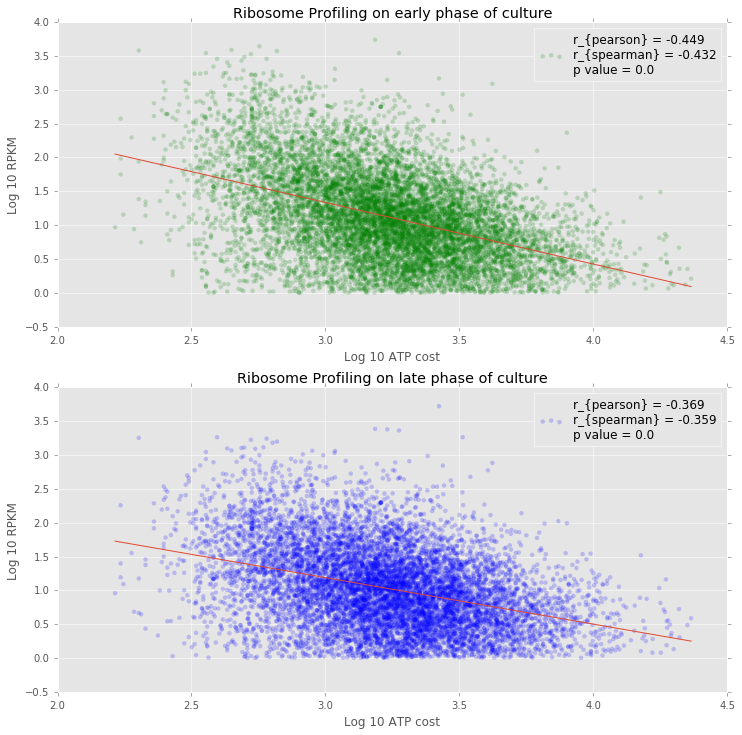

In [46]:
# Make scatter plots
ribo = pd.read_excel('NB3_Kallehauge_QpPredictions_Riboseq.xlsx')
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
X = np.log10(np.array(ribo['Length_cho'])*4.0 + (np.array(ribo['Length_cho'])/40) + 24.0)
Y = np.log10(ribo['ribo_day3'])
indexes = [i for i in range(len(Y)) if Y[i] >= 0]
X = X[indexes] # Take only genes with RPKM values greater or equal than 1
Y = Y[indexes]
# Compute correlations
P,Pp_val = sc.pearsonr(X,Y)
S,Sp_val = sc.spearmanr(X,Y)
plt.scatter(X,Y,alpha=0.2,c='green',edgecolors='none',label='r_{pearson} = '+ str(round(P,3)) + '\nr_{spearman} = ' + str(round(S,3)) \
           + '\np value = ' + str(round(Pp_val,3)))
plt.ylabel('Log 10 RPKM')
plt.xlabel('Log 10 ATP cost')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))
plt.legend(loc='upper right')
plt.title('Ribosome Profiling on early phase of culture')

plt.subplot(2,1,2)
X = np.log10(np.array(ribo['Length_cho'])*4.0 + (np.array(ribo['Length_cho'])/40) + 24.0)
Y = np.log10(ribo['ribo_day6'])
indexes = [i for i in range(len(Y)) if Y[i] >= 0]
X = X[indexes] # Take only genes with RPKM values greater or equal than 1
Y = Y[indexes]
# Compute correlations
P,Pp_val = sc.pearsonr(X,Y)
S,Sp_val = sc.spearmanr(X,Y)
plt.scatter(X,Y,alpha=0.2,c='blue',edgecolors='none',label='r_{pearson} = '+ str(round(P,3)) + '\nr_{spearman} = ' + str(round(S,3)) \
           + '\np value = ' + str(round(Pp_val,3)))
plt.ylabel('Log 10 RPKM')
plt.xlabel('Log 10 ATP cost')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))
plt.legend(loc='upper right')
plt.title('Figure 3B - Ribosome Profiling on late phase of culture')

## Repeat analysis with other CHO cell lines

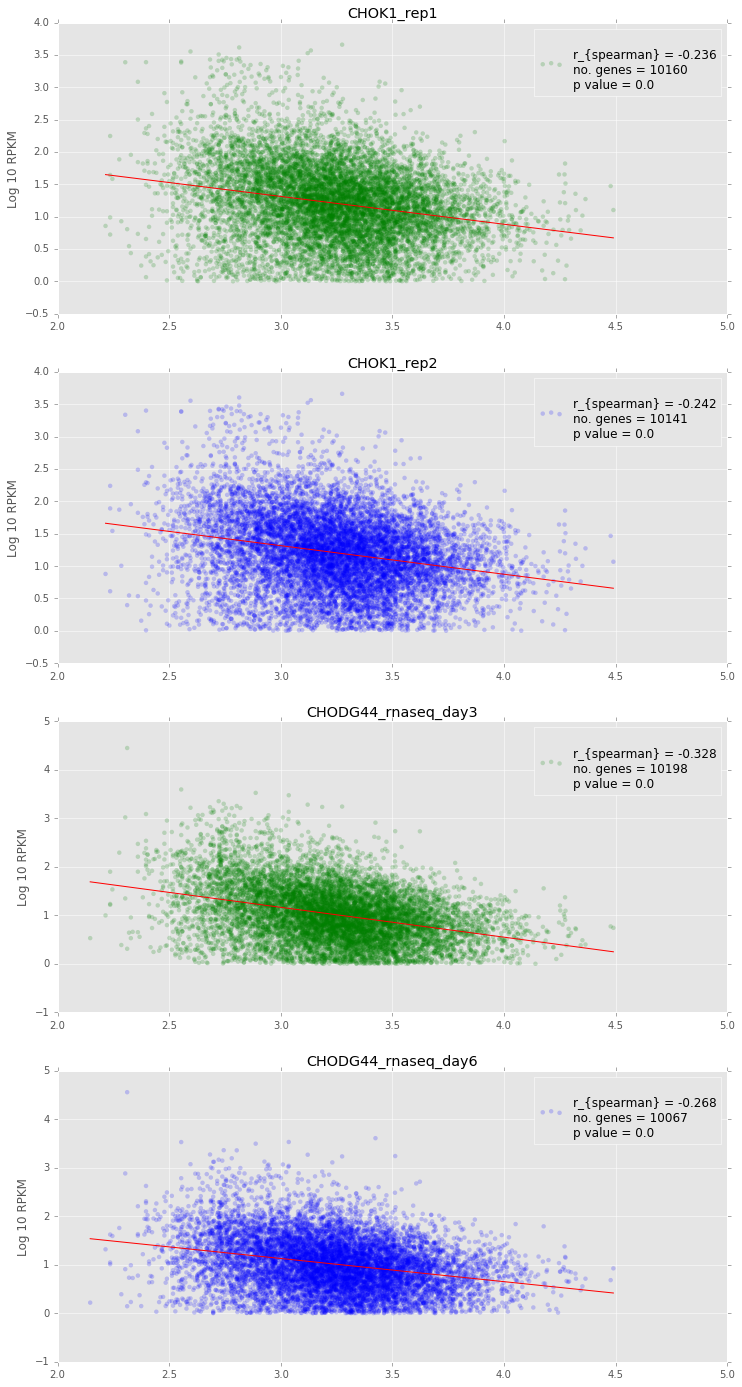

In [17]:
df = pd.read_csv('NB3_RNA-seq_CHOK1_CHODG44.csv',header=0)
# Make scatter plots of RNA-seq
plt.figure(figsize=(12,24))
samples = ['CHOK1_rep1','CHOK1_rep2','CHODG44_rnaseq_day3', 'CHODG44_rnaseq_day6']
for k in range(len(samples)):
    if k%2 == 0:
        COLOR = 'green'
    else:
        COLOR = 'blue'
    plt.subplot(4,1,k+1)
    L = [len(i) for i in list(df['pr_seq'])]
    X = np.log10(np.array(L)*4.0 + (np.array(L)/40) + 24.0) # Approximate value of ATP cost
    Y = np.log10(df[samples[k]])
    indexes = [i for i in range(len(Y)) if Y[i] >= 0]
    X = X[indexes] # Take only genes with RPKM values greater or equal than 1
    Y = Y[indexes]
    # Compute correlations
    S,Sp_val = sc.spearmanr(X,Y)
    plt.scatter(X,Y,alpha=0.2,c=COLOR,edgecolors='none',label='\nr_{spearman} = ' + str(round(S,3))
                + '\nno. genes = ' + str(len(Y)) + '\np value = ' + str(round(Pp_val,3)))
    plt.ylabel('Log 10 RPKM')
    #plt.xlabel('Log 10 ATP cost')
    plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)),c='red')
    plt.legend(loc='upper right')
    plt.title(samples[k])

# Repeat analysis across human tissues from the Human Protein Atlas

In [12]:
rna_tissue = pd.read_csv('NB3_HPA_rna_tissue.csv',header=0)
rna_cell = pd.read_csv('NB3_HPA_rna_celline.csv',header=0)
master_df = pd.read_csv('NB3_human_protein_atlas_metadata.csv',header=0)

In [46]:
# Compute correlations for all tissues
tissues = list(set(rna_tissue['Sample']))
S_correlations = []
p_values = []
no_genes = []
for i in range(len(tissues)):
    tissue_name = tissues[i]
    tissue = rna_tissue[rna_tissue['Sample']==str(tissue_name)].copy()
    tissue.index = range(len(tissue))
    test = pd.merge(master_df,tissue,on='Gene')
    X=np.array(test['Length'])
    X = (X*4.0) + (len(X)/40.) + 24 # Approximate ATP cost function
    Y=np.array(test['Value'])
    X = X[Y>=1]
    Y = Y[Y>=1]
    X = np.log10(X)
    Y = np.log10(Y)
    S,Sp_val = sc.spearmanr(X,Y)
    n = len(Y)
    S_correlations.append(S)
    p_values.append(Sp_val)
    no_genes.append(n)

In [47]:
# Make a dataframe
df = pd.DataFrame()    
df['Tissue'] = tissues
df['Spearman'] = np.array(S_correlations)
df['p-value'] = np.array(p_values)
df['Number of genes'] = np.array(no_genes)
df = df.sort_values(by='Spearman',ascending=True)
df.index=range(len(df))
df

,Tissue,Spearman,p-value,Number of genes
0,liver,-0.260348,1.071014e-175,11381
1,pancreas,-0.243453,1.833904e-125,9293
2,salivary gland,-0.227176,4.159870e-134,11465
3,skeletal muscle,-0.225342,1.877211e-116,10100
4,kidney,-0.221392,4.430533e-145,13092
5,heart muscle,-0.215708,2.706697e-126,11996
6,adrenal gland,-0.214617,2.564733e-139,13391
7,epididymis,-0.210110,3.891672e-133,13356
8,colon,-0.208342,4.345080e-130,13273
9,breast,-0.195483,1.518420e-117,13637


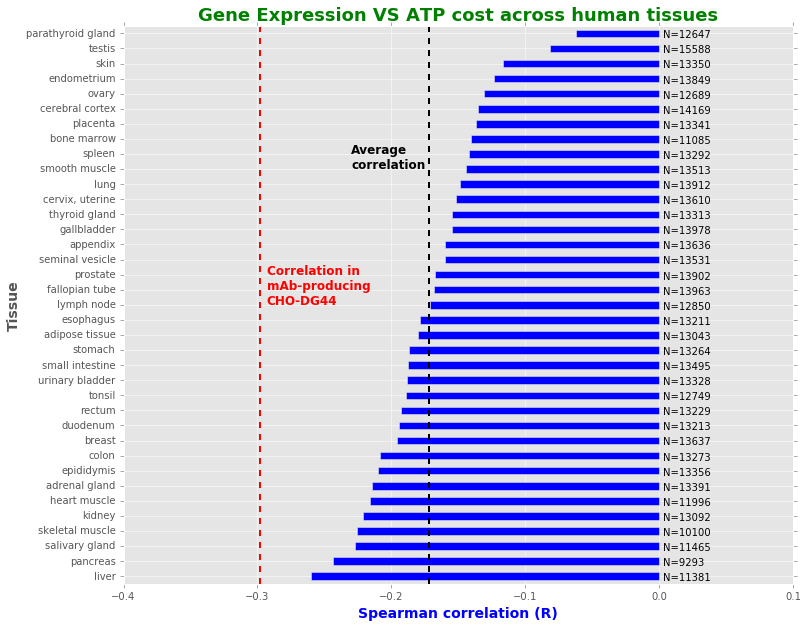

In [48]:
#Make a barplot of the data
fig, ax = plt.subplots(figsize=(12,10))
df.plot(kind='barh', x='Tissue', y='Spearman',ax=ax)
cho_avg = -0.298 # Correlation in mAb-producing CHO cells (RNA-seq)
ax.set_xlim([-0.4,0.1])
ax.set_xlabel('Spearman correlation (R)',fontsize=14,fontweight='bold',color='blue')
ax.set_ylabel('Tissue',fontsize=14,fontweight='bold')
ax.set_title('Gene Expression VS ATP cost across human tissues',fontsize=18,fontweight='bold',color='green')

# Annotate the CHO average legend
ax.text(cho_avg+0.005, 18, "Correlation in\nmAb-producing\nCHO-DG44",fontsize=12,fontweight='bold',color='red')

# Annotate the average correlation across tissues
avg_correlations = np.mean(df['Spearman'])
ax.text(-0.23, 27, "Average\ncorrelation",fontsize=12,fontweight='bold',color='black')

# Annote number of genes in each tissue
gene_numbers=list(df['Number of genes'])
for i in range(len(df)):
    ax.text(0.0025,i-0.3,"N="+str(gene_numbers[i]),fontsize=10)

# Add a line for the average
ax.axvline(x=cho_avg, color='r', label='CHO-DG44 (Average)', linestyle='--', linewidth=2)
ax.axvline(x=avg_correlations, color='k', label='Average Spearman across tissues', linestyle='--', linewidth=2)

ax.legend().set_visible(False)

# Repeat analysis across cell lines from the Human Protein Atlas

In [49]:
# Compute correlations for all cell lines
tissues = list(set(rna_cell['Sample']))
S_correlations = []
p_values = []
no_genes = []
for i in range(len(tissues)):
    tissue_name = tissues[i]
    tissue = rna_cell[rna_cell['Sample']==str(tissue_name)].copy()
    tissue.index = range(len(tissue))
    test = pd.merge(master_df,tissue,on='Gene')
    X=np.array(test['Length'])
    X = (X*4.0) + (len(X)/40.) + 24 # Approximate ATP cost function
    Y=np.array(test['Value'])
    X = X[Y>=1]
    Y = Y[Y>=1]
    X = np.log10(X)
    Y = np.log10(Y)
    S,Sp_val = sc.spearmanr(X,Y)
    n = len(Y)
    S_correlations.append(S)
    p_values.append(Sp_val)
    no_genes.append(n)

In [50]:
# Make a dataframe
df = pd.DataFrame()    
df['Cell line'] = tissues
df['Spearman'] = np.array(S_correlations)
df['p-value'] = np.array(p_values)
df['Number of genes'] = np.array(no_genes)
df = df.sort_values(by='Spearman',ascending=True)
df.index=range(len(df))
df

,Cell line,Spearman,p-value,Number of genes
0,RPTEC TERT1,-0.251552,1.493485e-165,11506
1,SK-MEL-30,-0.238611,1.165839e-143,11113
2,PC-3,-0.237144,8.316992e-147,11505
3,RPMI-8226,-0.230222,2.414113e-128,10669
4,hTCEpi,-0.226496,2.723682e-128,11028
5,Hep G2,-0.225431,6.765640e-125,10836
6,NB-4,-0.225172,4.637178e-122,10611
7,MCF7,-0.215761,1.464214e-115,10955
8,HEK 293,-0.214924,3.523634e-123,11783
9,EFO-21,-0.212805,2.238815e-123,12044


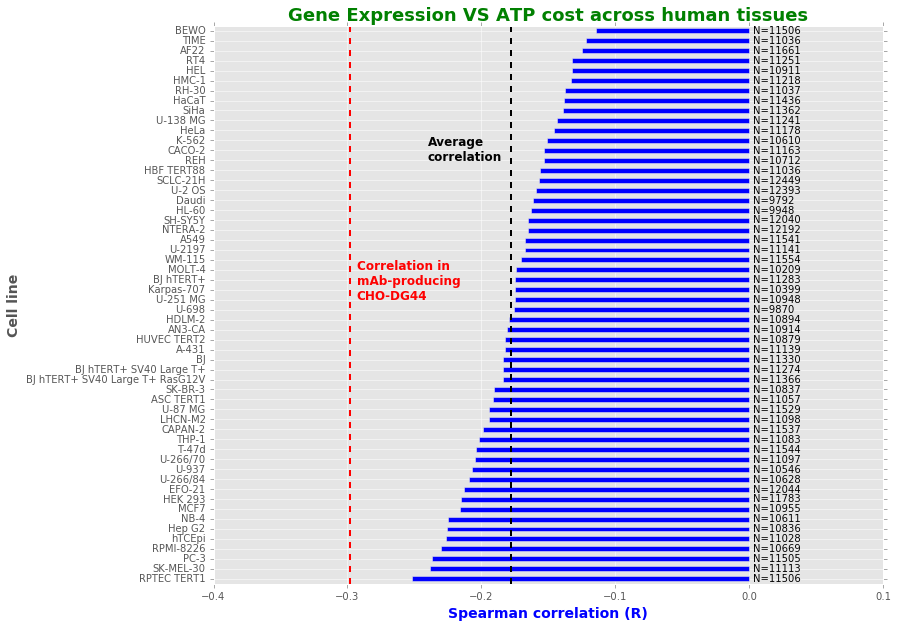

In [51]:
#Make a barplot of the data
fig, ax = plt.subplots(figsize=(12,10))
df.plot(kind='barh', x='Cell line', y='Spearman',ax=ax)
cho_avg = -0.298 # Correlation in mAb-producing CHO cells (RNA-seq)
ax.set_xlim([-0.4,0.1])
ax.set_xlabel('Spearman correlation (R)',fontsize=14,fontweight='bold',color='blue')
ax.set_ylabel('Cell line',fontsize=14,fontweight='bold')
ax.set_title('Gene Expression VS ATP cost across human tissues',fontsize=18,fontweight='bold',color='green')

# Annotate the CHO average legend
ax.text(cho_avg+0.005, len(df)/2, "Correlation in\nmAb-producing\nCHO-DG44",fontsize=12,fontweight='bold',color='red')

# Annotate the average correlation across tissues
avg_correlations = np.mean(df['Spearman'])
ax.text(-0.24, len(df)*0.75, "Average\ncorrelation",fontsize=12,fontweight='bold',color='black')

# Annote number of genes in each tissue
gene_numbers=list(df['Number of genes'])
for i in range(len(df)):
    ax.text(0.0025,i-0.3,"N="+str(gene_numbers[i]),fontsize=10)

# Add a line for the average
ax.axvline(x=cho_avg, color='r', label='CHO-DG44 (Average)', linestyle='--', linewidth=2)
ax.axvline(x=avg_correlations, color='k', label='Average Spearman across cell lines', linestyle='--', linewidth=2)

ax.legend().set_visible(False)